# Dogs vs Cats Redux

Kaggle assignment

### Use kaggle-cli to download the competition files, extract them to train/ and test/

```bash
cd data/catsdogs.2
mkdir test/ train/ validate/ sample/ results/
unzip -d test/ original_data/test.zip 
unzip -d train/ original_data/train.zip 
```
   
### Create directories train/dog, train/cat, validate/dog, validate/cat

```bash
mkdir train/cat train/dog validate/cat validate/dog test/unknown
```

### Move all the cats, dogs, unknown to respective categories

```bash
mv train/dog* train/dog/
mv train/cat* train/cat/
mv test/* test/unknown
```

### Take some 1000 images in random from train/cat , train/dog and move to validate/cat, validate/dog

```bash
shuf -n 1000 -e train/cat/* | xargs -i mv {} validate/cat
shuf -n 1000 -e train/dog/* | xargs -i mv {} validate/dog

```
### Copy some 10 images from train/cat,dog & validate/cat,dog to sample/train,validate/cat,dog

```bash
mkdir sample/train sample/train/cat sample/train/dog sample/validate/cat sample/validate/dog sample/test sample/test/unknown sample/results
shuf -n 10 -e train/cat/* | xargs -i cp {} sample/train/cat
shuf -n 10 -e train/dog/* | xargs -i cp {} sample/train/dog
shuf -n 10 -e validate/cat/* | xargs -i cp {} sample/validate/cat
shuf -n 10 -e validate/dog/* | xargs -i cp {} sample/validate/dog
shuf -n 10 -e test/unknown/* | xargs -i cp {} sample/test/unknown
```

## Code

In [205]:
from vgg16 import Vgg16
from __future__ import print_function
vgg16 = Vgg16()
%matplotlib inline

In [206]:
path = 'data/dogscats.2/'# + 'sample/'
train_path = path + 'train/'
validate_path = path + 'validate/'
test_path = path + 'test/'
results_path = path + 'results/'
predictions_path = results_path + 'predictions.dat'
prediction_filenames_path = results_path + 'filenames.dat'

In [211]:
#Constants
batch_size = 20
no_of_epochs = 4
learning_rate = 0.01

## Create Batches

In [212]:
training_batches = vgg16.get_batches(train_path, batch_size=batch_size)
validation_batches = vgg16.get_batches(validate_path, batch_size=batch_size * 2)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Fine tune &  Fit while saving weights in iterations

In [213]:
vgg16.finetune(training_batches)
vgg16.model.optimizer.lr = learning_rate

In [214]:
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print('Running epoch: %d' % epoch)
    vgg16.fit(training_batches, validation_batches, nb_epoch=1)
    latest_weights_filename = 'batch-%d-epoch-%d-lr-%0.3f.h5' % (batch_size, epoch, learning_rate)
    vgg16.model.save_weights(results_path+latest_weights_filename)

Running epoch: 0
Epoch 1/1
23000/23000 [==============================] - 401s - loss: 0.4400 - acc: 0.9675 - val_loss: 0.2384 - val_acc: 0.9825
Running epoch: 1
Epoch 1/1
23000/23000 [==============================] - 411s - loss: 0.4168 - acc: 0.9720 - val_loss: 0.2755 - val_acc: 0.9820
Running epoch: 2
Epoch 1/1
23000/23000 [==============================] - 411s - loss: 0.3829 - acc: 0.9746 - val_loss: 0.2025 - val_acc: 0.9855
Running epoch: 3
Epoch 1/1
23000/23000 [==============================] - 408s - loss: 0.4055 - acc: 0.9735 - val_loss: 0.2893 - val_acc: 0.9815


## Test with validation set and obtain predictions

In [215]:
batches, predictions = vgg16.test(test_path, batch_size=batch_size*2)

Found 12500 images belonging to 1 classes.


In [216]:
#serialize the predictions
from utils import *
filenames = batches.filenames
save_array(predictions_path, predictions)
save_array(prediction_filenames_path, filenames)

## Confusion Matrix

In [240]:
#testing with the validation set
v_batch, v_preds = vgg16.test(validate_path, batch_size=batch_size*2)

Found 2000 images belonging to 2 classes.


In [242]:
filenames = v_batch.filenames
expected_labels = v_batch.classes

In [243]:
# Get Dog Predictions and round them to get labels
our_predictions = v_preds[:,1]
predicted_labels = np.round(our_predictions)

In [244]:
from keras.preprocessing import image

def plot_idx(idx, titles=None):
    images = [image.load_img(validate_path+filenames[i]) for i in idx]
    plots(images, titles=titles)

n_view = 5

Number of correct predictions: 1963


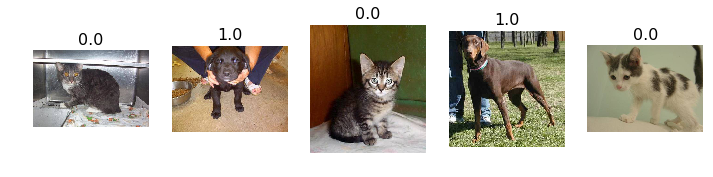

In [248]:
# Correct Predictions

correct = np.where(predicted_labels==expected_labels)[0]

print('Number of correct predictions:', len(correct))
idx = permutation(correct)[:n_view]
plot_idx(idx, predicted_labels[idx])

Number of incorrect predictions: 37


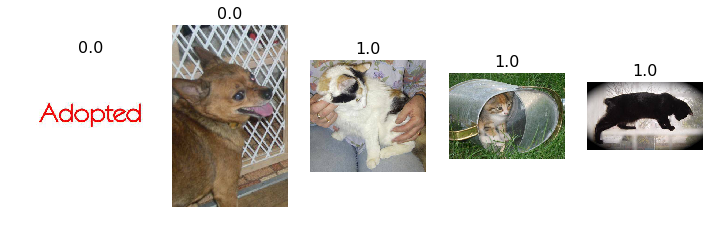

In [258]:
#Incorrect Predictions
incorrect = np.where(predicted_labels!=expected_labels)[0]
print('Number of incorrect predictions:', len(incorrect))
idx = permutation(incorrect)[:n_view]
plot_idx(idx, predicted_labels[idx])

Number of correct dog predictions: 984


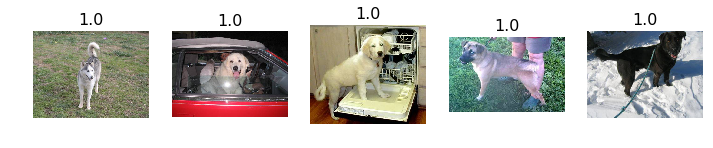

In [259]:
#Correct Dog Predictions
correct_dogs = np.where( (predicted_labels==1)  & (predicted_labels==expected_labels))[0]
print('Number of correct dog predictions:', len(correct_dogs))
idx = permutation(correct_dogs)[:n_view]
plot_idx(idx, predicted_labels[idx])

Number of correct cat predictions: 979


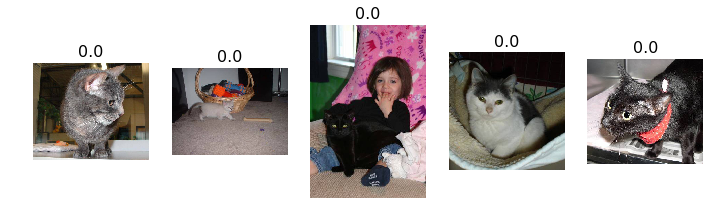

In [260]:
#Correct Cat Predictions
correct_cats = np.where( (predicted_labels==0)  & (predicted_labels==expected_labels))[0]
print('Number of correct cat predictions:', len(correct_cats))
idx = permutation(correct_cats)[:n_view]
plot_idx(idx, predicted_labels[idx])

Number of incorrect dog predictions: 21


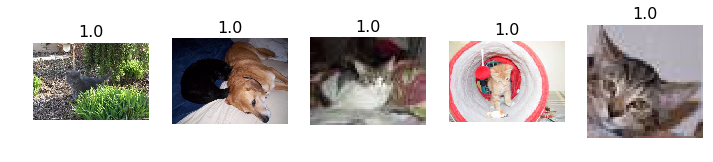

In [266]:
#Incorrect Dog Predictions - Cats predicted as Dogs
incorrect_dogs = np.where( (predicted_labels==1)  & (predicted_labels!=expected_labels))[0]
print('Number of incorrect dog predictions:', len(incorrect_dogs))
if len(incorrect_dogs):
    idx = incorrect_dogs[np.argsort(our_predictions[incorrect_dogs])[::-1][:n_view]]
    plot_idx(idx, predicted_labels[idx])

Number of incorrect cat predictions: 16


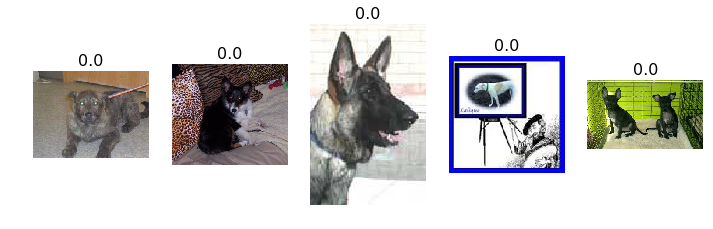

In [267]:
#Incorrect Cat Predictions - Dogs predicted as cats
incorrect_cats = np.where( (predicted_labels==0)  & (predicted_labels!=expected_labels))[0]
print('Number of incorrect cat predictions:', len(incorrect_cats))

if len(incorrect_cats):
    idx = incorrect_cats[np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]]
    plot_idx(idx, predicted_labels[idx])

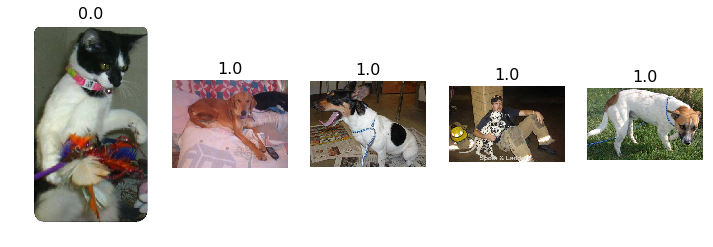

In [268]:
#Ambiguous
most_uncertain = np.argsort(np.abs(predicted_labels-0.5))
plot_idx(most_uncertain[:n_view], predicted_labels[most_uncertain])

[[979  21]
 [ 16 984]]


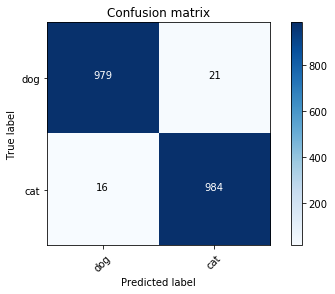

In [269]:
from sklearn.metrics import confusion_matrix

cnf_mat = confusion_matrix(expected_labels, predicted_labels)
plot_confusion_matrix(cnf_mat, v_batch.class_indices)

## Load saved preds, Clip predictions to reduce log loss over confidence

In [291]:
filenames = load_array(prediction_filenames_path)
predictions = load_array(predictions_path)
dog_predictions = predictions[:,1] #Get column 1
dog_predictions = dog_predictions.clip(0.01, 0.99)


## Format and save predictions for kaggle submission

In [292]:
ids = np.array([int(f[len('unknown/'):f.find('.')]) for f in filenames])

result = np.stack([ids,dog_predictions], axis=1)

kaggle_submit_csv = results_path + 'submission.csv'

np.savetxt(kaggle_submit_csv, result, fmt='%d,%.5f', header='id,label', comments='')

In [293]:
from IPython.display import FileLink
FileLink(kaggle_submit_csv)

/home/sai/Desktop/fast-ai/deeplearning/notebooks/data/dogscats.2/results/submission.csv